In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import deepchem as dc
from deepchem.molnet import load_qm7, load_qm7_from_mat
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import Draw, rdDepictor
from IPython.display import SVG

from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

%matplotlib inline

### Load data set 


In [2]:
dataset_file = "raw_data/gdb7.sdf"

qm7_tasks = ["u0_atom"]

featurizer = dc.feat.CoulombMatrix(max_atoms=23)

loader = dc.data.SDFLoader(
  tasks=['u0_atom'],
  smiles_field="smiles",
  mol_field="mol",
  featurizer=featurizer)

dataset = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
Reading structures from raw_data/gdb7.sdf.
Currently featurizing feature_type: CoulombMatrix
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 3.907 s
TIMING: dataset construction took 5.864 s
Loading dataset from disk.


In [7]:
splitter = dc.splits.SingletaskStratifiedSplitter(task_number=0)

train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

transformer = dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset, move_mean=True)

train_trans = transformer.transform(train_dataset)
valid_trans = transformer.transform(valid_dataset)
test_trans = transformer.transform(test_dataset)


TIMING: dataset construction took 0.372 s
Loading dataset from disk.
TIMING: dataset construction took 0.160 s
Loading dataset from disk.
TIMING: dataset construction took 0.169 s
Loading dataset from disk.


/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/trans/transformers.py:148: RuntimeWarning: divide by zero encountered in true_divide
  X = np.nan_to_num((X - self.X_means) / self.X_stds)
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/trans/transformers.py:148: RuntimeWarning: invalid value encountered in true_divide
  X = np.nan_to_num((X - self.X_means) / self.X_stds)


TIMING: dataset construction took 0.469 s
Loading dataset from disk.
TIMING: dataset construction took 0.058 s
Loading dataset from disk.
TIMING: dataset construction took 0.057 s
Loading dataset from disk.


Hansen et al (2013) state that normalisation scaling of inputs is detrimental to model performance as the input dimensions are related. 
In this notebook, we will compare the performance of scaled and non-scaled inputs. 



In [8]:
print(train_dataset.get_shape())
print(valid_dataset.get_shape())
print(test_dataset.get_shape())

((5728, 23, 23), (5728, 1), (5728, 1), (5728,))
((716, 23, 23), (716, 1), (716, 1), (716,))
((716, 23, 23), (716, 1), (716, 1), (716,))


train ((5728, 23, 23), (5728, 1), (5728, 1), (5728,))
train (array([[4.36189166e+01, 1.47551583e+01, 8.73190833e+00, 6.80681517e+00,
        5.93337888e+00, 5.55602359e+00, 5.79273122e+00, 2.94389303e+00,
        2.63742767e+00, 2.14624925e+00, 1.18254835e+00, 9.81038352e-01,
        8.03944903e-01, 6.45212957e-01, 5.28738709e-01, 3.69236571e-01,
        2.81191177e-01, 1.56197195e-01, 9.37325518e-02, 4.04527216e-02,
        1.42287955e-02, 3.24406189e-03, 0.00000000e+00],
       [1.47551583e+01, 4.29481732e+01, 1.46562708e+01, 9.79646763e+00,
        8.01165808e+00, 7.34423089e+00, 7.25214313e+00, 1.62182391e+00,
        1.64854446e+00, 1.76108381e+00, 1.91484260e+00, 1.38085427e+00,
        1.01565977e+00, 8.18773846e-01, 6.61855618e-01, 4.64815810e-01,
        3.53041374e-01, 1.97862173e-01, 1.20010322e-01, 5.25874005e-02,
        1.77883379e-02, 4.06060267e-03, 0.00000000e+00],
       [8.73190833e+00, 1.46562708e+01, 4.33673320e+01, 1.40236629e+01,
        9.37523730e+00, 7.7089137

RDKit ERROR: [18:30:26] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [18:30:26] Explicit valence for atom # 3 

valid ((716, 23, 23), (716, 1), (716, 1), (716,))
valid (array([[4.25445985e+01, 1.47018431e+01, 8.56806974e+00, 6.81545450e+00,
        5.88943430e+00, 5.64886969e+00, 5.81571423e+00, 2.93232833e+00,
        2.62421593e+00, 2.15037656e+00, 1.19147568e+00, 9.65038651e-01,
        8.06423726e-01, 6.54133178e-01, 5.38792121e-01, 3.75234985e-01,
        2.64697938e-01, 1.56243561e-01, 9.10783535e-02, 3.84705598e-02,
        1.32713174e-02, 3.97118561e-03, 0.00000000e+00],
       [1.47018431e+01, 4.35541829e+01, 1.46379106e+01, 9.83620087e+00,
        7.98565008e+00, 7.43818867e+00, 7.32680660e+00, 1.61032960e+00,
        1.67341705e+00, 1.79459455e+00, 1.92890547e+00, 1.36770122e+00,
        1.02730684e+00, 8.16739253e-01, 6.70955654e-01, 4.67268973e-01,
        3.35666397e-01, 2.02220667e-01, 1.19490866e-01, 4.85766937e-02,
        1.67261786e-02, 5.24200798e-03, 0.00000000e+00],
       [8.56806974e+00, 1.46379106e+01, 4.28045396e+01, 1.40591402e+01,
        9.48201636e+00, 7.84994655e+0

RDKit ERROR: [18:30:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 5 

test (array([[4.49101961e+01, 1.48779938e+01, 8.76526546e+00, 7.05248569e+00,
        6.00759053e+00, 5.59349868e+00, 5.78518811e+00, 2.97568045e+00,
        2.62785810e+00, 2.05550389e+00, 1.17850502e+00, 9.90784565e-01,
        8.13994158e-01, 6.55921411e-01, 5.45799803e-01, 3.58382621e-01,
        2.63718057e-01, 1.56218119e-01, 8.73300569e-02, 3.72019709e-02,
        1.43195835e-02, 4.04051871e-03, 0.00000000e+00],
       [1.48779938e+01, 4.29495896e+01, 1.45909221e+01, 1.00106601e+01,
        8.07622592e+00, 7.28345319e+00, 6.94759888e+00, 1.63047066e+00,
        1.67697110e+00, 1.78633441e+00, 1.86037748e+00, 1.37085964e+00,
        1.01088845e+00, 8.09084496e-01, 6.62305392e-01, 4.48355745e-01,
        3.34137900e-01, 2.04286482e-01, 1.15203301e-01, 5.08575567e-02,
        1.90595924e-02, 5.34517370e-03, 0.00000000e+00],
       [8.76526546e+00, 1.45909221e+01, 4.31451565e+01, 1.41598691e+01,
        9.40276245e+00, 7.72790366e+00, 7.17140078e+00, 1.14393980e+00,
        1.370467

RDKit ERROR: [18:30:27] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:30:27] Explicit valence for atom # 3 

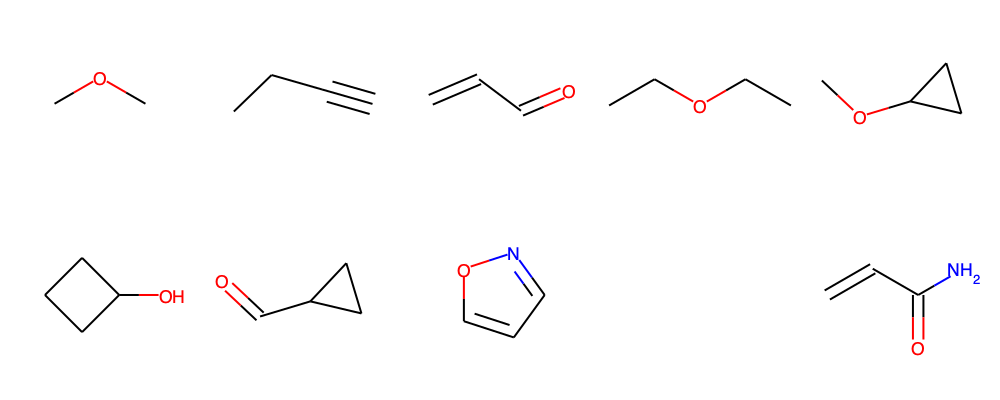

In [9]:
## Dataset analysis

for name,data in zip(['train', 'valid', 'test'],[train_dataset, valid_dataset, test_dataset]):
    print(name, data.get_shape())
    print(name, data.get_statistics(X_stats=True))
    mol_list = [Chem.MolFromSmiles(id_) for id_ in data.ids]
    #SVG(moltosvg(mol_list[0]))

Chem.Draw.MolsToGridImage(mol_list[:10], molsPerRow=5)#legends=[mol.GetProp('_Name') for mol in mol_list[:10]])

# mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
# Chem.Draw.MolsToGridImage(mol_list,legends=[mol.GetProp('_Name') for mol in mol_list])

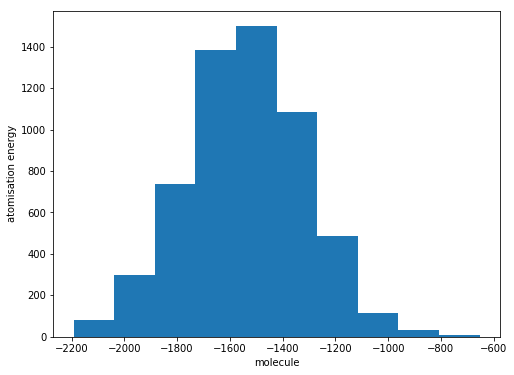

In [10]:
plt.figure(figsize=(8,6))
plt.hist(train_dataset.y)
plt.xlabel("molecule")
plt.ylabel("atomisation energy")
plt.show()

## Keras Neural Networks

In [19]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(400, input_shape=(23,23)),
    keras.layers.Flatten(),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(1)
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 23, 400)           9600      
_________________________________________________________________
flatten_3 (Flatten)          (None, 9200)              0         
_________________________________________________________________
activation_3 (Activation)    (None, 9200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               920100    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 929,801
Trainable params: 929,801
Non-trainable params: 0
_________________________________________________________________


In [25]:
train_dataset.X[:25].shape

(25, 23, 23)

In [26]:
## Keras implementation 
from tensorflow import keras

## Functions

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    #fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.figure(figsize=(8,6))
   # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train MSE')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Valid MSE')
#     plt.plot(hist['epoch'], hist['val_loss'],
#            label = 'Val Loss')
    plt.title(title)
    plt.legend()
    #plt.ylim([0,5])
    #ax[0].legend()
    plt.show()
    

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        #self.lr.append(step_decay(len(self.losses)))

loss_history = LossHistory()

Model parameters and weights inspired by Hansen et al (2015) Journal of Physical Chemistry Letters

Initial weights W0 and learning rates γ are chosen as W0 ∼ N(0, 1/√m) and γ = γ0/√m where m is the number of input units and γ0 is the global learning rate of the network set to γ0 = 0.01. 

In [34]:
init_layer1 = keras.initializers.RandomNormal(mean=0, stddev=(1/np.sqrt(400)))
init_layer2 = keras.initializers.RandomNormal(mean=0, stddev=(1/np.sqrt(100)))
#lr = 0.01/np.sqrt(400)
lr = 0.001
# Network

model = tf.keras.Sequential([
keras.layers.Dense(400, input_shape=([23, 23]), kernel_initializer=init_layer1, activation='sigmoid'),
#keras.layers.Dense(400, kernel_initializer=init_layer1, activation='sigmoid'),
keras.layers.Dense(100, activation='sigmoid', kernel_initializer=init_layer2),
keras.layers.Dense(1)])

# Optimizer
sgd = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam()
# Configure a model for mean-squared error regression.
model.compile(optimizer=adam,
              loss='mae',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')

# Save model weights checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint('sgd_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')

# Train on dataset

X_train = train_trans.X
y_train = train_trans.y

# Validate on dataset

X_valid = valid_trans.X
y_valid = valid_trans.y


In [35]:
print(X_train[:25].shape)
print(y_train.shape)
model.summary()

(25, 23, 23)
(5728, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 23, 400)           9600      
_________________________________________________________________
dense_23 (Dense)             (None, 23, 100)           40100     
_________________________________________________________________
dense_24 (Dense)             (None, 23, 1)             101       
Total params: 49,801
Trainable params: 49,801
Non-trainable params: 0
_________________________________________________________________


In [32]:
# history = model.fit(X_train, y_train, validation_split = 0.1, epochs=500, 
#                     callbacks=[early_stop, loss_history], batch_size=25, verbose=0)

history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=500, 
                    callbacks=[early_stop, loss_history], batch_size=25, verbose=0)



InvalidArgumentError: Incompatible shapes: [25,23,1] vs. [25,1]
	 [[{{node training_2/Adam/gradients/loss_2/dense_18_loss/sub_grad/BroadcastGradientArgs}}]]

In [ ]:
plot_history(history, "SGD model")

In [ ]:
loss_history.lr

In [ ]:
epochs = 50
# plot learning rate
fig = plt.figure()
plt.plot(range(1,epochs+1),loss_history.lr,label='learning rate')
plt.xlabel("epoch")
plt.xlim([1,epochs+1])
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()

In [ ]:
# Test
from sklearn import metrics 

X_test = test_dataset.X
y_test = test_dataset.y

print("shape X_test: ", X_test.shape)
print("shape y_test: ", y_test.shape)

predictions = model.predict(X_test)
scores = model.evaluate(X_test, y_test)
errors = {}

errors['mean_absolute_error'] = metrics.mean_absolute_error(y_test, predictions)
errors['mean_squared_error'] = metrics.mean_squared_error(y_test, predictions)


# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
# #ax[1].bar(['mae', 'pearsons_r2'], test_scores)
# plt.title("Kernel ridge regression")
# plt.ylabel("mean absolute error")
# plt.show()

results = pd.DataFrame(predictions, columns = ['y_pred'])
results['y_true'] = y_test
sns.pairplot(results, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
plt.title("Neural network model")
plt.annotate('$R^2$=%.2f, MAE=%.2f' % (metrics.r2_score(y_valid, predictions), 
                                       metrics.mean_absolute_error(y_valid, predictions)), 
                                    xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()


In [ ]:
scores

## Kernel Ridge Regression 

In [ ]:
from deepchem.models.tensorgraph.optimizers import ExponentialDecay
from sklearn.kernel_ridge import KernelRidge
tf.set_random_seed(123)

## Kernel ridge regression

def krr_model_builder(model_dir):
    sklearn_model = KernelRidge(kernel='laplacian', alpha=0.0001, gamma=0.0001)
    return dc.models.SklearnModel(sklearn_model, model_dir)

regression_metric = dc.metrics.Metric(
    dc.metrics.mean_absolute_error, mode="regression")

krr = dc.models.SingletaskToMultitask(tasks, krr_model_builder)

# Fit trained model
krr.fit(train_dataset)
#model.save()

train_evaluator = dc.utils.evaluate.Evaluator(krr, train_dataset, transformers)
train_scores = train_evaluator.compute_model_performance([regression_metric])

print("Train scores [kcal/mol]")
print(train_scores)

test_evaluator = dc.utils.evaluate.Evaluator(krr, test_dataset, transformers)
test_scores = test_evaluator.compute_model_performance([regression_metric])

print("Validation scores [kcal/mol]")
print(test_scores)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
#ax[1].bar(['mae', 'pearsons_r2'], test_scores)
plt.title("Kernel ridge regression")
plt.ylabel("mean absolute error")
plt.show()

## DTNN

In [ ]:
# Load QM7 dataset
# tasks, datasets, transformers = dc.molnet.load_qm7_from_mat(move_mean=False)
# train_dataset, valid_dataset, test_dataset = datasets

# Fit models
metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

# Batch size of models
batch_size = 50
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

dtnn_model = dc.models.DTNNModel(
    len(tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")

# Fit trained model
model.fit(train_dataset, nb_epoch=50)

train_scores = model.evaluate(train_dataset, metric, transformers)
valid_scores = model.evaluate(valid_dataset, metric, transformers)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
#ax[1].bar(['mae', 'pearsons_r2'], test_scores)
plt.title("Deep tensor neural network")
plt.ylabel("mean absolute error")
plt.show()

## Single task NN 

In [ ]:
from deepchem.molnet import load_qm7_from_mat
from deepchem.models.tensorgraph.optimizers import ExponentialDecay

print(tf.__version__)

qm7_tasks, datasets, transformers = load_qm7_from_mat(
    split='stratified', move_mean=True, reload=False)


qm_train, qm_valid, qm_test = datasets

fit_transformers = [dc.trans.CoulombFitTransformer(qm_train)]

rate = 0.001
dc_model = dc.models.MultitaskFitTransformRegressor(
    n_tasks=1,
    n_features=[23, 23],
    learning_rate=rate,
    momentum=.8,
    batch_size=25,
    weight_init_stddevs=[1 / np.sqrt(400), 1 / np.sqrt(100), 1 / np.sqrt(100)],
    bias_init_consts=[0., 0., 0.],
    layer_sizes=[400, 100, 100],
    dropouts=[0.01, 0.01, 0.01],
    fit_transformers=fit_transformers,
    n_evals=10,
    seed=123)




In [ ]:
# Fit trained model
dc_model.fit(qm_train, nb_epoch=50)

train_scores = dc_model.evaluate(qm_train, metric, transformers)
valid_scores = dc_model.evaluate(qm_valid, metric, transformers)